In [11]:
import numpy as np
import pandas as pd
import rasterio as rio
# from os.path import join, basename
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import sys
sys.path.append("..")
from utils import (
    DATA_PATH,
    version,
    geo_slices,
    slice_tropics,
    dense_vegetation
)

terra = rio.open(DATA_PATH + "/terraaqua.tif", 'r').read(1)
cmap_terra = colors.ListedColormap(['white', '#D7D7D7FF'])

In [3]:
# read Tcrit map
tcrit_map = rio.open(DATA_PATH + '/outputs/Tcrit_map_mean_1981_2010_v15.tif', 'r').read(1)
tcrit_map.shape

(21122, 43199)

In [4]:
# read TSM 2020 map
tsm_2020_map = np.load(DATA_PATH + f"/outputs/TSM_2020{version}.npy")
tsm_2020_map.shape

(7794, 32198)

In [5]:
# read Linear Regression TSM map
lr_tsm_map = np.load(DATA_PATH + '/outputs/LinearRegression_TSM_2001_2020_v15.npy')
lr_tsm_map.shape

(7794, 32198)

In [6]:
# Slice Tcrit map to tropics and mask where TSM map is masked
tcrit_map = tcrit_map[slice_tropics]
tcrit_map[np.isnan(tsm_2020_map)] = np.nan  
tcrit_map.shape

(7794, 32198)

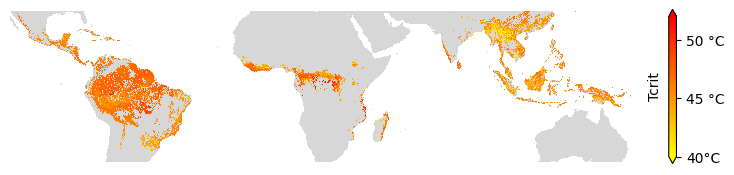

In [32]:
# Plot Tcrit map (supplementary figure)
fig, ax = plt.subplots(figsize=(10,5))

ax.imshow(terra[slice_tropics], cmap=cmap_terra)

minn = 40
maxx = 52
cmap = colors.LinearSegmentedColormap.from_list("tcrit", ["yellow", "red"])
im = ax.imshow(tcrit_map, cmap=cmap, interpolation='none')
im.set_clim(minn, maxx)
ax.set_axis_off()
# keep map rasterized
ax.set_rasterization_zorder(0) 
im.set_zorder(0)
im.set_rasterized(True) 

cbar = fig.colorbar(
    im, extend='both', shrink=0.4, ticks = [40, 45, 50],
    format= mticker.FixedFormatter(['40°C', '45 °C', '50 °C']),)
cbar.ax.set_ylabel('Tcrit', rotation=90, labelpad=-55, fontdict={'fontsize': 10})
plt.savefig("figures/resubmission/Tcrit.pdf", bbox_inches='tight')

In [14]:
# Function to make a shifted colormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. 
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = colors.LinearSegmentedColormap(name, cdict)
    return newcmap

/tmp/ipykernel_2195619/3947265970.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


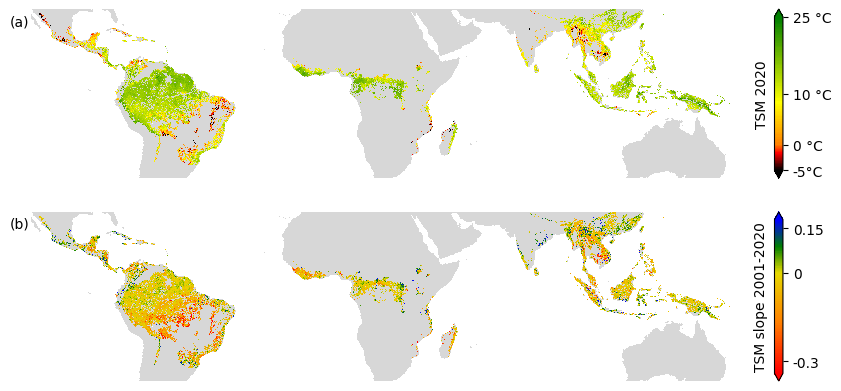

In [30]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10,4), gridspec_kw={'left': 0.05, 'right': 0.95, 'top': 0.98, 'bottom': 0.05})

for ax in [ax1, ax2]:
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()

# Plot TSM 2020 map (figure 1a)
colors_ = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 0.5, 0)]
cmap_tsm = colors.LinearSegmentedColormap.from_list('tsm', colors_, N=100)
minn = -5
maxx = 25
cmap_tsm_shifted = shiftedColorMap(cmap_tsm, midpoint=(-minn)/(maxx - minn), name='tsm_shifted')
cmap_tsm_shifted.set_bad(alpha=0)
im = ax1.imshow(tsm_2020_map, cmap=cmap_tsm_shifted, interpolation='none')
im.set_clim(minn, maxx)
# keep map rasterized
ax1.set_rasterization_zorder(0) 
im.set_zorder(0)
im.set_rasterized(True) 
# colorbar
cbar = fig.colorbar(
    im, extend='both', shrink=1, ticks = [-5, 0, 10, 25],
    format= mticker.FixedFormatter([f'-5°C', '0 °C', '10 °C', f'25 °C']),)
cbar.ax.set_ylabel('TSM 2020', rotation=90, labelpad=-55, fontdict={'fontsize': 10})
ax1.text(-0.03, 0.97, '(a)', transform=ax1.transAxes,fontsize=10, va='top', ha='left')

# Plot Linear Regression TSM map (figure 1b)
colors_ = [(1, 0, 0), (1,0.5,0), (0.9, 0.85, 0), (0, 0.5, 0), (0,0,1)]
cmap_lr = colors.LinearSegmentedColormap.from_list('lr_tsm', colors_, N=100)
minn = -0.34
maxx = 0.18
cmap_lr_shifted = shiftedColorMap(cmap_lr, midpoint=(-minn)/(maxx - minn), name='tsm_shifted')
cmap_lr_shifted.set_bad(alpha=0)
im = ax2.imshow(lr_tsm_map, cmap=cmap_lr_shifted, interpolation='none')
im.set_clim(minn, maxx)
# keep map rasterized
ax2.set_rasterization_zorder(0) 
im.set_zorder(0)
im.set_rasterized(True) 
# color bar
cbar = fig.colorbar(
    im, extend='both', shrink=1, ticks = [-0.3, 0, 0.15],
    format= mticker.FixedFormatter([-0.3,0,0.15]),)
cbar.ax.set_ylabel('TSM slope 2001-2020', rotation=90, labelpad=-50, fontdict={'fontsize': 10})
ax2.text(-0.03, 0.97, '(b)', transform=ax2.transAxes,fontsize=10, va='top', ha='left')

plt.tight_layout()
plt.savefig("figures/resubmission/TSM_figure.pdf", bbox_inches='tight')


In [11]:
data = {}
for continent, slice in geo_slices.items():
    tsm_2001_2020_data = np.load(DATA_PATH + f"/outputs/TSM_2001_2020_{continent}_{version}.npy")

    data[continent] = {
        '2001': tsm_2001_2020_data[...,0].flatten(), 
        '2020': tsm_2001_2020_data[...,-1].flatten(),
        '2050': np.load(DATA_PATH + f"/outputs/TSM_2050_{continent}_{version}.npy").flatten(),
        '2050 acc.': np.load(DATA_PATH + f"/outputs/TSM_2050_acclim_{continent}_{version}.npy").flatten(),
        '2100': np.load(DATA_PATH + f"/outputs/TSM_2100_{continent}_{version}.npy").flatten(),
        '2100 acc.': np.load(DATA_PATH + f"/outputs/TSM_2100_acclim_{continent}_{version}.npy").flatten(),
    }

south_america
africa
south_east_asia


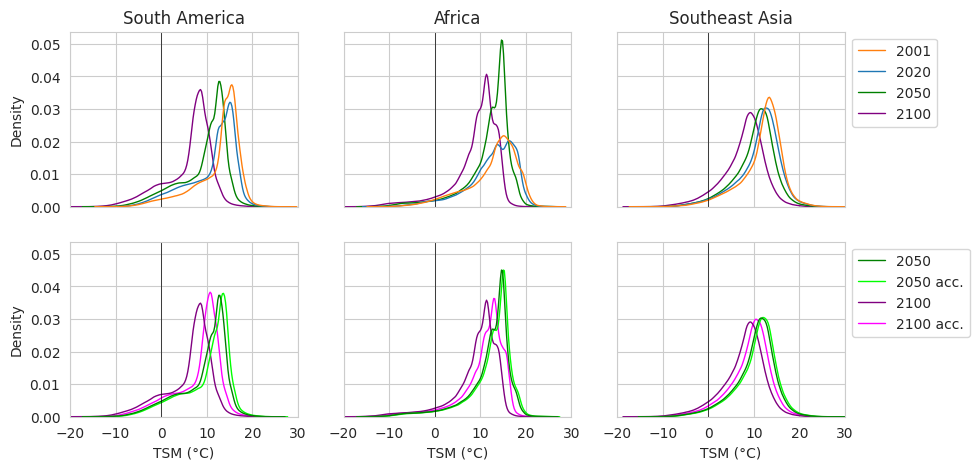

In [28]:
sns.set_style("whitegrid")
fig, (axs_top, axs_bottom) = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
colors_top = ['tab:orange', 'tab:blue', 'green', 'purple']
colors_bottom = ['green', 'lime', 'purple', 'fuchsia']

for ax1, ax2, continent, continent_title in zip(
    axs_top, axs_bottom, 
    ['south_america', 'africa', 'south_east_asia'], 
    ["South America", "Africa", "Southeast Asia"]
):
    print(continent)
    df = pd.DataFrame(data[continent]).dropna(axis=0, how='all')
    df1 = pd.melt(df[['2001','2020','2050','2100']], var_name='year', value_name='TSM').dropna()
    df2 = pd.melt(df[['2050','2050 acc.','2100','2100 acc.']], var_name='year', value_name='TSM').dropna()

    legend = False if continent != "south_east_asia" else True
    sns.kdeplot(df1, x='TSM', hue='year', palette=colors_top, legend=legend, fill=False, linewidth=1, ax=ax1)
    sns.kdeplot(df2, x='TSM', hue='year', palette=colors_bottom, legend=legend, fill=False, linewidth=1, ax=ax2)
    
    ax1.set_title(continent_title)
    ax2.set_xlabel('TSM (°C)')
    ax1.set_xlim((-20,30))
    ax1.axvline(0, color='black', linewidth=0.5)
    ax2.axvline(0, color='black', linewidth=0.5)
    if legend:
        sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1), title=None)
        sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), title=None)

plt.savefig("figures/resubmission/TSM_distributions.pdf", bbox_inches='tight')
plt.show()

In [ ]:
delta_tsurf_2050 = rio.open(DATA_PATH + '/2050-2100_temperatures/delta_tsurf_2020_2050.tif', 'r').read(1)
delta_tsurf_2100 = rio.open(DATA_PATH + '/2050-2100_temperatures/delta_tsurf_2020_2100.tif', 'r').read(1)
delta_tsurf_2050[delta_tsurf_2050==-20] = np.nan
delta_tsurf_2100[delta_tsurf_2100==-20] = np.nan

(5018, 9999, 20)

<Axes: ylabel='Density'>

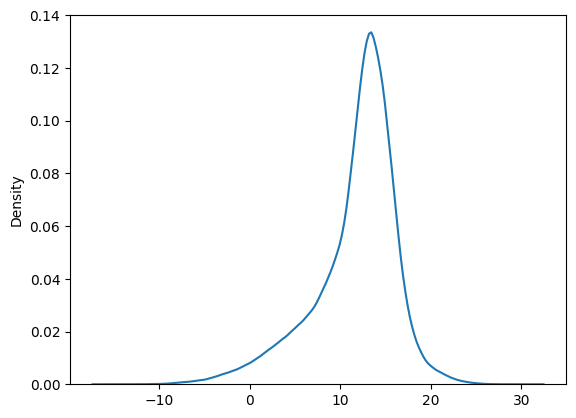

In [ ]:
fig, (axs_top, axs_bottom) = plt.subplots(2, 3, figsize=(10, 5))

for ax1, ax2, continent, continent_title in zip(
    axs_top, axs_bottom, 
    ['south_america', 'africa', 'south_east_asia'], 
    ["South America", "Africa", "Southeast Asia"]
):
    slice_delta_tsurf_2050 = delta_tsurf_2050[geo_slices[continent]]
    slice_delta_tsurf_2100 = delta_tsurf_2100[geo_slices[continent]]

    ax1.imshow(terra[geo_slices[continent]], cmap=cmap_terra)

    ax2.imshow(terra[geo_slices[continent]], cmap=cmap_terra)


    cmap_final = colormaps["Reds"]
    

<Axes: ylabel='Density'>

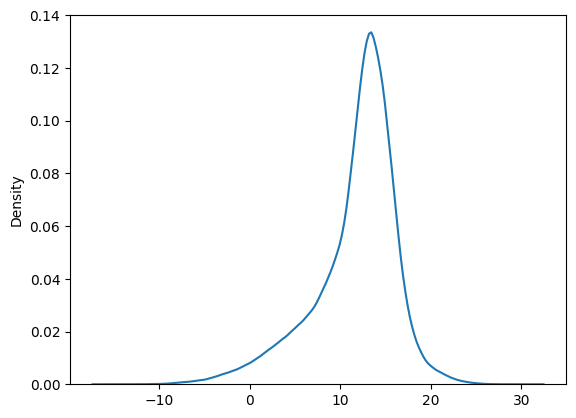

In [16]:
sns.kdeplot(tsm_data[...,0].flatten())

In [26]:
print(np.nanmin(mean_tcrit_map), np.nanmax(mean_tcrit_map))
print(np.nanmin(mean_tcrit_map_gaston), np.nanmax(mean_tcrit_map_gaston))

37.41881760486856 54.9583636836448
37.41881760486856 54.9583636836448


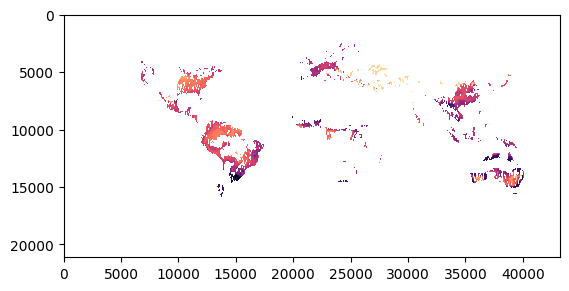

In [22]:
plt.imshow(mean_tcrit_map, vmin=40, vmax=50, cmap='magma')

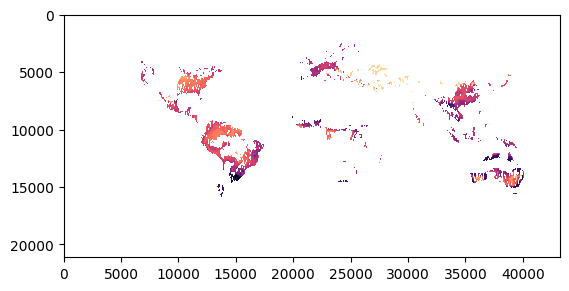

In [27]:
plt.imshow(mean_tcrit_map_gaston, vmin=40, vmax=50, cmap='magma')

In [3]:
data_both_biomes = np.zeros(mean_tcrit_map.shape, dtype=bool)
biomes = [
    "Tropical & Subtropical Moist Broadleaf Forests",
    "Tropical & Subtropical Dry Broadleaf Forests",
]
biome_files = [join(DATA_PATH, f"Ecoregions2017/{b}.tif") for b in biomes]
for biome_file in biome_files:
    data_biome = rio.open(biome_file, "r").read(1).squeeze()
    data_biome = data_biome.astype(bool)
    data_both_biomes += data_biome

In [18]:
tsm_map = np.zeros_like(data_both_biomes).astype(float)
tsm_map[:,:] = np.nan
for continent, slice in geo_slices.items():        
    tsm_file = DATA_PATH + f"/outputs/TSM_2001_2020_{continent}_{version}.npy"
    tsm_2020 = np.load(tsm_file)[...,-1]
    tsm_2020[~data_both_biomes[slice]] = np.nan
    tsm_2020[~dense_vegetation[slice]] = np.nan
    tsm_map[slice] = tsm_2020

In [24]:
geo_slices.keys()

dict_keys(['south_east_asia', 'south_america', 'africa'])

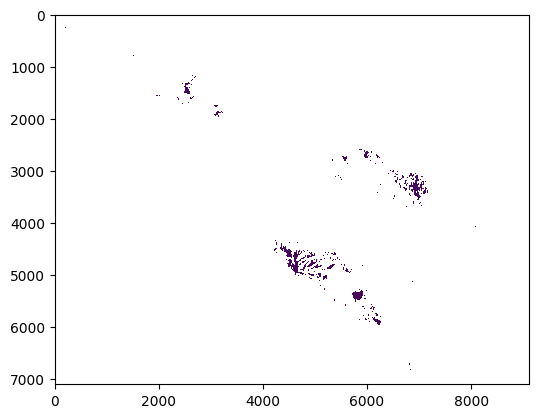

In [25]:
continent = 'south_america'
tsm_file = DATA_PATH + f"/outputs/TSM_2001_2020_{continent}_{version}.npy"
tsm_2020 = np.load(tsm_file)[...,-1]
plt.imshow(tsm_2020)

In [27]:
print(np.nanmin(tsm_2020), np.nanmax(tsm_2020))

-15.900008 1051.0881


In [28]:
print(np.nanmin(mean_tcrit_map), np.nanmax(mean_tcrit_map))

37.41881760486856 54.9583636836448


In [34]:
src = rio.open(join(modis_folder, basename(modis_files[-1])), "r")
m = src.read(1)

In [37]:
dense_vegetation.shape

(21122, 43199)

In [38]:
data_both_biomes.shape

(21122, 43199)

In [39]:
np.isnan(m).sum()

0

In [41]:
m[dense_vegetation == 0] = np.nan
m[~data_both_biomes] = np.nan
m[m == -1000] = np.nan

In [47]:
mean_tcrit_map.shape

(21122, 43199)

In [49]:
tsm = mean_tcrit_map[slice] - m[slice]

In [52]:
print(np.nanmin(tsm), np.nanmax(tsm))

-14.930009765625002 26.6480000203885


In [51]:
tsm.shape[0] * tsm.shape[1]

34595421

In [45]:
np.isnan(m).sum() / (m.shape[0] * m.shape[1])

0.9797249727233606

In [36]:
m.max()

61.649994

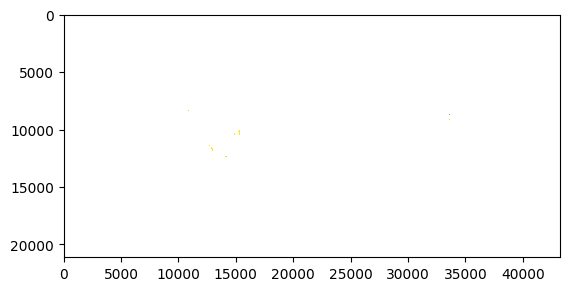

In [23]:
plt.imshow(tsm_map, vmin=-5, vmax= 10)

In [4]:
for continent, slice in geo_slices.items():        
    break

In [5]:
tsm_file = DATA_PATH + f"/outputs/TSM_2001_2020_{continent}_{version}.npy"
tsm_2020 = np.load(tsm_file)[...,-1]
tsm_2020[~data_both_biomes[slice]] = np.nan
tsm_2020.shape

(5018, 9999)

In [9]:
np.where(dense_vegetation[slice] != 0)

(array([   0,    0,    0, ..., 5017, 5017, 5017]),
 array([ 320,  321,  322, ..., 8521, 8522, 8526]))

In [14]:
np.where(~np.isnan(tsm_2020[np.where(dense_vegetation[slice] != 0)]))

(array([    381,     382,     383, ..., 6060019, 6060081, 6060082]),)

In [16]:
tsm_2020[np.where(dense_vegetation[slice] != 0)][381]

19.424603

In [ ]:
np.where(dense_vegetation[slice] != 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
np.all(np.isnan(tsm_2020[~dense_vegetation[slice]]))

MemoryError: Unable to allocate 1.83 TiB for an array with shape (5018, 9999, 9999) and data type float32